# Create Graph-based Clusters 

Created by: Orsi Vasarhelyi

Contact: orsolya.vasarhelyi@gmail.com

Last updated: 29.06.2018.

Content:
- ra on the filtered data
- connect to db and load in the comune-level aggreagated directed weighted graph
- import into networkx
- descriptive network statistics
- due to reciprocity of connections Itrasform the network into a an undirected graph becouse  clustering and edge-filtering is way easier and faster.
- apply disparity filtering on the graph to reveal the backbone structure of network
- useing the Louvain-modularity clustering to find  on-overlapping clusters 
- visualize the network
-  visualize the clusters on a map

Todo:
- repeat the process on Tuscany only
- filter our towers
- do overlapping community detection (k-clique percolation)

In [3]:

#analysis
import pandas as pd
import networkx as nx
import numpy as np 
import community
from collections import Counter, defaultdict
import geopandas as gpd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from colorsys import hls_to_rgb
% matplotlib inline

#disparity filtering
import scipy as sp
import numpy as np
import math
import cmath
import csv
import itertools
import sys
import unicodedata
import string
from scipy.stats import hypergeom
from math import log
from scipy import special

import sys
sys.path.append("..")
from connect_db import db_connection

In [2]:
# Get attribute file of comunes

df = gpd.read_file('/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Com2016_WGS84_g/Com2016_WGS84_g.dbf')

In [3]:
df.head()

,COD_REG,COD_CM,COD_PRO,PRO_COM,COMUNE,NOME_TED,FLAG_CM,SHAPE_Leng,SHAPE_Area,geometry
0,1,201,1,1001,AgliÃ¨,None,1,16097.848335,1.330696e+07,"POLYGON ((404703.5575000001 5026682.6538, 4053..."
1,1,201,1,1002,Airasca,None,1,16684.218595,1.595353e+07,"POLYGON ((380700.9084000001 4977305.519300001,..."
2,1,201,1,1003,Ala di Stura,None,1,29892.862842,4.575251e+07,"POLYGON ((364710.8563000001 5022090.677200001,..."
3,1,201,1,1004,Albiano d'Ivrea,None,1,16192.656544,1.103356e+07,"POLYGON ((415942.5033 5033304.608200001, 41607..."
4,1,201,1,1005,Alice Superiore,None,1,18083.459633,7.508489e+06,(POLYGON ((406290.8252999997 5036266.583799999...


In [4]:
df['pro_com']=df['PRO_COM'].astype(float)

In [5]:
commune_names=df[['COMUNE', 'PRO_COM', 'pro_com']]

In [6]:
new_labels=commune_names.set_index('pro_com')[['COMUNE']].to_dict()['COMUNE']

### Get network data

In [4]:
# connect db
username='ovasarhelyi'
cred_location = '/mnt/data/'+username+'/utils/data_creds_redshift.json.nogit'
db = db_connection.DBConnection(cred_location)

In [5]:
query="select pro_com, new_pro_com, weight_filtered from tpt.tuscany.edgelist_comune_italy limit 10"

In [6]:
edgelist= db.sql_query_to_data_frame(query, cust_id=False)

In [7]:
edgelist.head()

,pro_com,new_pro_com,weight_filtered
0,83097,15202,0
1,30079,50037,0
2,95059,106010,0
3,16049,49007,0
4,12130,75028,0


In [11]:
edgelist=edgelist.rename(columns={'weight_filtered':'weight'})

In [12]:
edgelist=edgelist[edgelist['weight']>0]

In [13]:
len(edgelist)

1801233

In [14]:
# read into directed graph
G_dir=nx.from_pandas_edgelist(edgelist, 'pro_com', 'new_pro_com', edge_attr=['weight'], create_using=nx.DiGraph())

In [15]:
G2_dir=nx.relabel_nodes(G_dir, new_labels, copy=True)

In [16]:
G2_dir.number_of_nodes()

6064

In [17]:
G2_dir.number_of_edges()

1801230

In [18]:
# read into undirected-graph
G=nx.from_pandas_edgelist(edgelist, 'pro_com', 'new_pro_com', edge_attr=['weight'], create_using=nx.Graph())

In [19]:
G2=nx.relabel_nodes(G, new_labels, copy=True)

In [20]:
G2.number_of_nodes()

6064

In [21]:
G2.number_of_edges()

1186776

## Network Descriptives

In [22]:
# comapre densities of the two graphs
nx.density(G2), nx.density(G2_dir)

(0.06455828575680944, 0.048991688850186496)

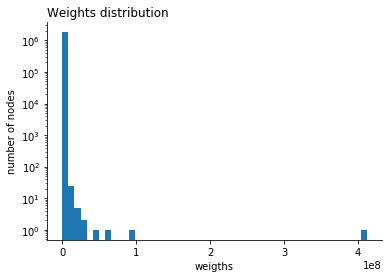

In [23]:
# Weights Distribution 

plt.hist((edgelist['weight']),bins=50)    
#plt.hist((weights_norm),bins=50)
plt.title("Weights distribution", loc='left')
plt.ylabel("number of nodes")
plt.xlabel("weigths")
plt.yscale('log', nonposy='clip')
sns.despine()
plt.show()


In [24]:
#out-degree
node_attrs=pd.DataFrame.from_dict(dict(G2_dir.out_degree()), 'index').rename(columns={0:'out_degree'})

In [25]:
#in-degree
node_attrs=node_attrs.join(pd.DataFrame.from_dict(dict(G2_dir.in_degree()), 'index').rename(columns={0:'in_degree'}))

In [26]:
# weighted out-degree
node_attrs=node_attrs.join(pd.DataFrame.from_dict(dict(G2_dir.out_degree(weight='weight')), 'index').rename(columns={0:'weighted_out_degree'}))

In [27]:
# weighted in-degree
node_attrs=node_attrs.join(pd.DataFrame.from_dict(dict(G2_dir.in_degree(weight='weight')), 'index').rename(columns={0:'weighted_in_degree'}))

In [28]:
# add comune regions and names
node_attrs=node_attrs.join(df.set_index('COMUNE')[["COD_REG","COD_CM", "COD_PRO", "PRO_COM"]])

In [29]:
#Top communies where people are going from outside Tuscany
node_attrs[node_attrs["COD_REG"]!=9].sort_values('weighted_in_degree', ascending=False)[:15]

,out_degree,in_degree,weighted_out_degree,weighted_in_degree,COD_REG,COD_CM,COD_PRO,PRO_COM
Roma,4848,4863,98320068.0,98376690.0,12,258,58,58091
Venezia,3556,3565,28136667.0,28173031.0,5,227,27,27042
Milano,3468,3450,17533866.0,17538672.0,3,215,15,15146
Bologna,3257,3300,16581672.0,16591180.0,8,237,37,37006
La Spezia,2642,2647,12660290.0,12668852.0,7,0,11,11015
Genova,2641,2659,11926594.0,11940375.0,7,210,10,10025
Riomaggiore,1899,2006,7242897.0,7240610.0,7,0,11,11024
Monterosso al Mare,1735,1830,6802622.0,6804047.0,7,0,11,11019
Sasso Marconi,2422,2367,6565208.0,6569596.0,8,237,37,37057
Castiglione del Lago,2268,2245,6556907.0,6556201.0,10,0,54,54009


In [30]:
#Top communies where people are coming from outside Tuscany
node_attrs[node_attrs["COD_REG"]!=9].sort_values('weighted_out_degree', ascending=False)[:15]

,out_degree,in_degree,weighted_out_degree,weighted_in_degree,COD_REG,COD_CM,COD_PRO,PRO_COM
Roma,4848,4863,98320068.0,98376690.0,12,258,58,58091
Venezia,3556,3565,28136667.0,28173031.0,5,227,27,27042
Milano,3468,3450,17533866.0,17538672.0,3,215,15,15146
Bologna,3257,3300,16581672.0,16591180.0,8,237,37,37006
La Spezia,2642,2647,12660290.0,12668852.0,7,0,11,11015
Genova,2641,2659,11926594.0,11940375.0,7,210,10,10025
Riomaggiore,1899,2006,7242897.0,7240610.0,7,0,11,11024
Monterosso al Mare,1735,1830,6802622.0,6804047.0,7,0,11,11019
Sasso Marconi,2422,2367,6565208.0,6569596.0,8,237,37,37057
Castiglione del Lago,2268,2245,6556907.0,6556201.0,10,0,54,54009


In [31]:
node_attrs[["weighted_out_degree","weighted_in_degree"]].corr()

,weighted_out_degree,weighted_in_degree
weighted_out_degree,1.0,1.0
weighted_in_degree,1.0,1.0


#### FINDING: weighted out-degree and weighted in-degree is very similar so I will use only the directed graph as first approach

### Visualize directed graph to have some idea how it looks like

In [32]:
d = dict(G2.degree())

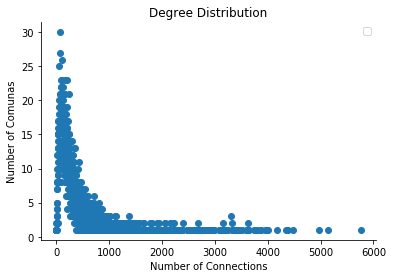

In [33]:
pd.DataFrame.from_dict(Counter(list(d.values())), 'index').sort_index().plot( title='Degree Distribution', style="o")
plt.legend("")
plt.xlabel("Number of Connections")
plt.ylabel("Number of Comunas")
sns.despine()

Based  on the Degree Distribution we can see that the network holds the properties of a typical small-world network,w hich is atypical for road networks. Most nodes has a few connections, and some have a lot, emaning we have hubs.

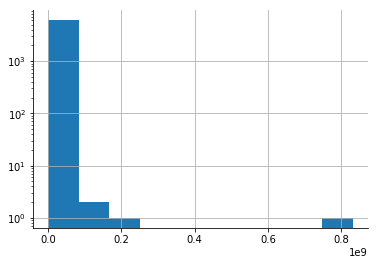

In [34]:
d2 = dict(G2.degree(weight='weight'))
pd.DataFrame.from_dict(d2, 'index')[0].hist(log=True)
sns.despine()

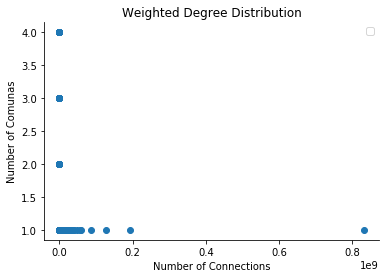

In [35]:
d2 = dict(G2.degree(weight='weight'))
pd.DataFrame.from_dict(Counter(list(d2.values())), 'index').sort_index().plot(title='Weighted Degree Distribution', style="o")
plt.legend("")
plt.xlabel("Number of Connections")
plt.ylabel("Number of Comunas")
sns.despine()

# Visualize the Network itself

In [36]:
def visualize_network(G,s,x, outfile):
    part = community.best_partition(G, weight='weight') #calculate best parttion for each node
    values = [part.get(node) for node in G.nodes()] #get the values for each node
    counterx=Counter(values)
    print ('Number of communities by the Louven method: '+str(len(counterx.keys())))
    print ('Modularity: '+str(community.modularity(part, G)))
    pos=nx.fruchterman_reingold_layout(G, scale=s)
    nx.draw(G, pos=pos, 
        cmap = plt.get_cmap('jet'), 
        node_color = values, 
        edge_color='#A6AFB4', 
        width=0.5 ,
        node_size=[i*x for i in dict(G.degree()).values()], #Node size based on the number of connections
        with_labels=False)
    plt.show()
    plt.savefig(outfile)
    return part

Number of communities by the Louven method: 60
Modularity: 0.9024746013672829


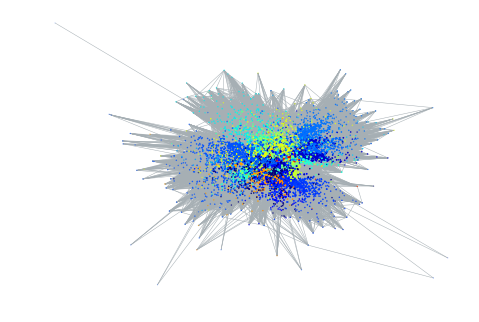

<Figure size 432x288 with 0 Axes>

In [37]:
clusters_big=visualize_network(G2,18,0.004, "communities_all.pdf")

In [38]:
node_attrs=node_attrs.join(pd.DataFrame.from_dict(clusters_big, 'index')).rename(columns={0:'cluster_full'})

In [39]:
node_attrs.head()

,out_degree,in_degree,weighted_out_degree,weighted_in_degree,COD_REG,COD_CM,COD_PRO,PRO_COM,cluster_full
Abano Terme,617,659,425996.0,426958.0,5,0,28,28001,24
Abbadia Lariana,89,72,407.0,382.0,3,0,97,97001,45
Abbadia San Salvatore,1241,1106,852180.0,851411.0,9,0,52,52001,31
Abbasanta,100,114,4237.0,4229.0,20,0,95,95001,21
Abbiategrasso,257,240,8838.0,8855.0,3,215,15,15002,10


## Disparity filtering (backbone filtering)

Disparity filter is a network reduction algorithm to extract the backbone structure of undirected weighted network [8]. The advantage of the filtering method is that it does not destroy the multi-scale nature of the network. The algorithm is developed by M. Angeles Serrano, Marian Boguna and Alessandro Vespignani. Basicaly it gives back the backbone structure of the filterable network that is why it is also called the backbone filtering
 In my Backbone test alpha is equal to 10/2L, where L is the number of links.

In [40]:
P=nx.to_pandas_edgelist(G2)

In [41]:
P.to_csv('comune_edges.csv', index=False, header=False)

In [42]:
def extract_backbone(network, alpha, directed):
    nodes = set()
    edges = set()
    for n in network:
        k_n = len(network[n])
        if k_n > 1:
            sum_w = sum(network[n][nj] for nj in network[n])
            for nj in network[n]:
                pij = 1.0 * network[n][nj] / sum_w
                if (1 - pij) ** (k_n - 1) < alpha:
                    nodes.add(n)
                    nodes.add(nj)
                    if directed==True:
                        edges.add((n, nj, network[n][nj]))
                    else:
                        if n < nj:
                            edges.add((n, nj, network[n][nj]))
                        else:
                            edges.add((nj, n, network[nj][n]))
    return edges

In [43]:
def backbone_test(graph_df, a, infile, outfile, directed):

    f = open(infile, "r")
    network = defaultdict(lambda : defaultdict(float))
    for line in f:
        fields = line.strip().split(',')
        network[fields[0]][fields[1]] = float(fields[2])
        network[fields[1]][fields[0]] = float(fields[2])
    f.close()
    
    directed = ("n")
    edgesc=[]

    alpha=float(a)/(2*len(graph_df))
    
    edges=extract_backbone(network, alpha, directed)
    
    with open(outfile, 'w') as csvfile:
        writer=csv.writer(csvfile)
        for (fr,to,weight) in edges:
            writer.writerow((fr,to,weight))

    
    G = nx.read_weighted_edgelist(outfile, delimiter=',')
    print ("Number of nodes:"+str(G.number_of_nodes()))
    print ("Number of edges:"+str(G.number_of_edges()))
    print ('Network Desity: '+str(nx.density(G)))
    giant = max(nx.connected_component_subgraphs(G), key=len)
    print ('Percentage of the number of nodes belonging to the giant component: '+str(float(giant.number_of_nodes())/float(G.number_of_nodes())))
    d = dict(nx.degree(G))
    plt.hist(d.values(),bins=50)
    plt.title("Degree Distribution Histogram")
    plt.ylabel("number of nodes")
    plt.xlabel("degree")
    plt.yscale('log', nonposy='clip')
    plt.show()

    weights=[]
    for (_,_,k) in edges:
        weights.append(k)
    print ("min:"+str(min(weights)))
    print ("max:"+str(max(weights)))
    print ("SD:"+str(np.std(weights)))

In [44]:
G2.number_of_nodes()

6064

In [45]:
G2.number_of_edges()

1186776

Number of nodes:5964
Number of edges:14672
Network Desity: 0.0008251195360434731
Percentage of the number of nodes belonging to the giant component: 0.5543259557344065


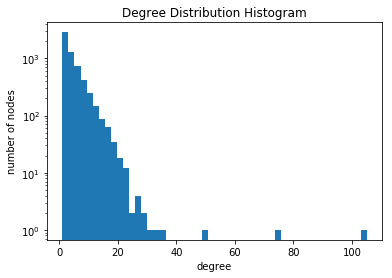

min:18.0
max:411533830.0
SD:3615047.6782738883


In [46]:
backbone_test(P, 10, "comune_edges.csv", "comune_edges_backbone.csv", False)

In [47]:
e=pd.read_csv("comune_edges_backbone.csv", header=-1).rename(columns={0:'from', 1:'to', 2:'weight'})

In [48]:
G_filtered=nx.from_pandas_edgelist(e, 'from', 'to', edge_attr=['weight'], create_using=nx.Graph())

In [49]:
giant = max(nx.connected_component_subgraphs(G_filtered), key=len)

Number of communities by the Louven method: 97
Modularity: 0.9100961428850454


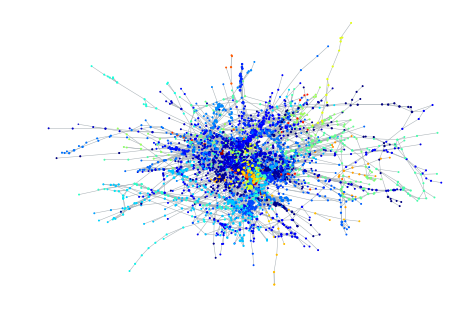

<Figure size 432x288 with 0 Axes>

In [50]:
cluster_filtered_giant=visualize_network(giant, 6, 0.3, 'filtered_network.pdf')

In [51]:
node_attrs=node_attrs.join(pd.DataFrame.from_dict(cluster_filtered_giant, 'index')).rename(columns={0:'cluster_filtered_giant'})

Number of communities by the Louven method: 2236
Modularity: 0.910868969533897


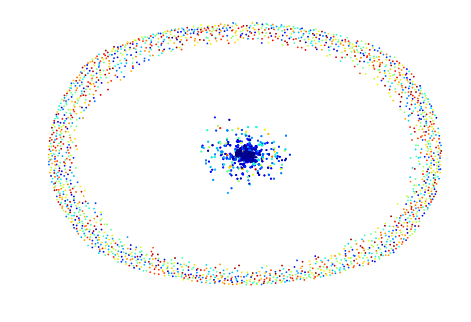

<Figure size 432x288 with 0 Axes>

In [52]:
cluster_filtered=visualize_network(G_filtered, 6, 0.3, 'filtered_network_full.pdf')

In [53]:
node_attrs=node_attrs.join(pd.DataFrame.from_dict(cluster_filtered, 'index')).rename(columns={0:'cluster_filtered'})

In [54]:
node_attrs.head()

,out_degree,in_degree,weighted_out_degree,weighted_in_degree,COD_REG,COD_CM,COD_PRO,PRO_COM,cluster_full,cluster_filtered_giant,cluster_filtered
Abano Terme,617,659,425996.0,426958.0,5,0,28,28001,24,17.0,50.0
Abbadia Lariana,89,72,407.0,382.0,3,0,97,97001,45,NaN,1561.0
Abbadia San Salvatore,1241,1106,852180.0,851411.0,9,0,52,52001,31,38.0,44.0
Abbasanta,100,114,4237.0,4229.0,20,0,95,95001,21,NaN,108.0
Abbiategrasso,257,240,8838.0,8855.0,3,215,15,15002,10,NaN,258.0


# Plot the results on a map

In [55]:
# load data from TPT 
regions = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Reg2016_WGS84_g/Reg_2016_WGS84_g.shp"
provinces = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/CMProv2016_WGS84_g/CMprov2016_WGS84_g.shp"
municipalities = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Com2016_WGS84_g/Com2016_WGS84_g.shp"
new_reg =  r"/mnt/data/shared/ITA_shapefiles/Tus_28districts.shp"

# important cities 
important_cities_file = r"/mnt/data/shared/important_cities.csv"

In [56]:
df_reg = gpd.read_file(regions)
df_pro = gpd.read_file(provinces)
df_mun = gpd.read_file(municipalities)
df_newreg = gpd.read_file(new_reg)
important_cities = pd.read_csv(important_cities_file)

df_reg_tusc = df_reg[df_reg["COD_REG"] == 9] # tuscany
df_pro_tusc = df_pro[df_pro["COD_REG"] == 9]
df_mun_tusc = df_mun[df_mun["COD_REG"] == 9]

# Convert coordinates in WGS84 to Lat Lon format (DO NOT use for the _github files)
# see http://geopandas.org/projections.html
df_reg_tusc['geometry'] = df_reg_tusc['geometry'].to_crs(epsg=4326)
df_pro_tusc['geometry'] = df_pro_tusc['geometry'].to_crs(epsg=4326)
df_mun_tusc['geometry'] = df_mun_tusc['geometry'].to_crs(epsg=4326)

/home/ovasarhelyi/.conda/envs/velf/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/ovasarhelyi/.conda/envs/velf/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ovasarhelyi/.conda/envs/velf/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [57]:
df_mun2=df_mun.set_index('COMUNE').join(node_attrs[['cluster_full', "cluster_filtered_giant", "cluster_filtered"]])

In [58]:
len(df_mun2['cluster_full'].value_counts())

60

In [59]:
df_mun2=df_mun2.replace(np.nan,999999)

In [60]:


def get_distinct_colors(n):

    colors = []

    for i in np.arange(0., 360., 360. / n):
        h = i / 360.
        l = (50 + np.random.rand() * 10) / 100.
        s = (90 + np.random.rand() * 10) / 100.
        colors.append(hls_to_rgb(h, l, s))

    return colors

In [61]:
import matplotlib

In [62]:
cs=get_distinct_colors(58)

In [63]:
cs[-1]=(1.,1.,1.)

In [64]:
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", cs)

/home/ovasarhelyi/.conda/envs/velf/lib/python3.6/site-packages/geopandas/plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


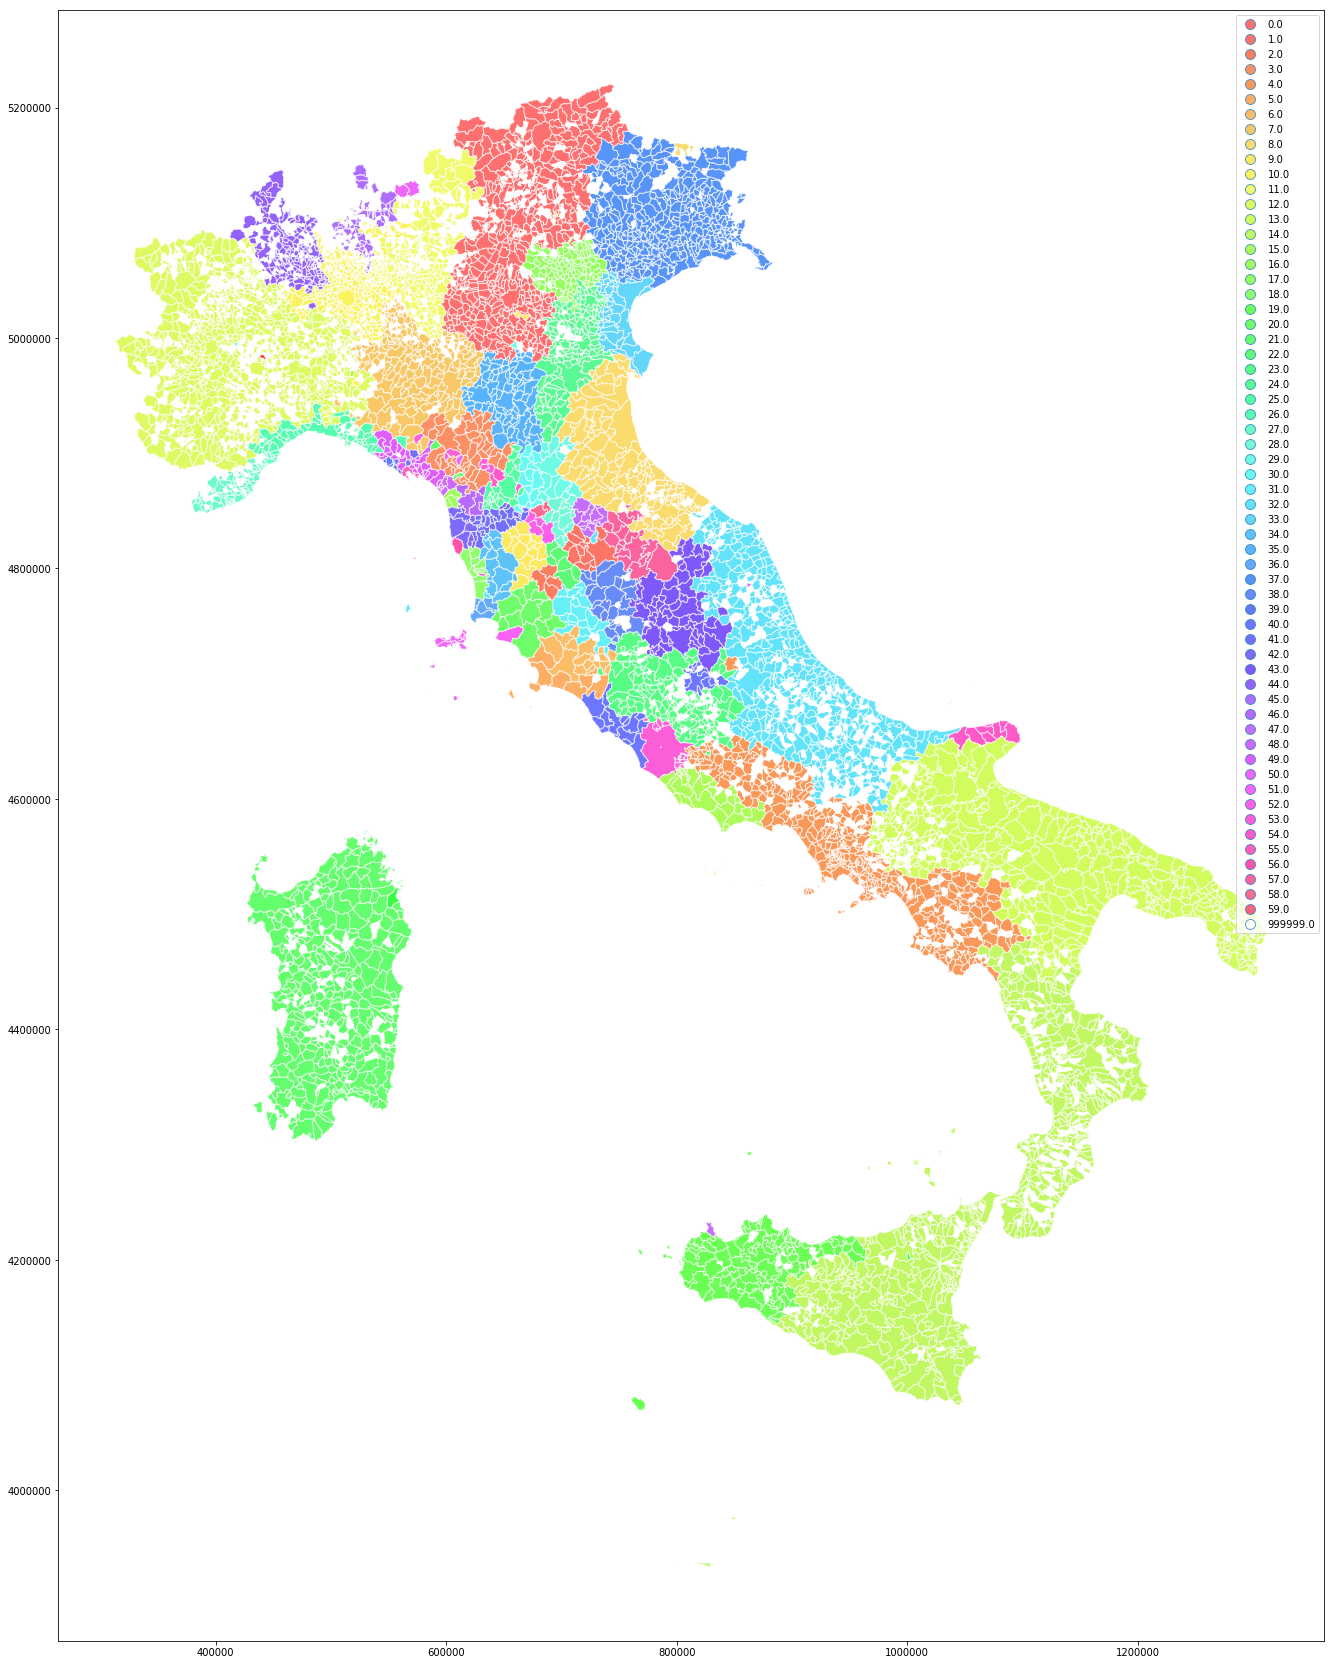

In [65]:
df_mun2.plot(column='cluster_full', colormap=cmap1, alpha=0.7, categorical=True, figsize=(30, 30), edgecolor='white', legend=True)

In [66]:
df_mun_tusc2=df_mun_tusc.set_index('COMUNE').join(node_attrs[['cluster_full', "cluster_filtered_giant", "cluster_filtered"]])

In [67]:
df_mun_tusc2=df_mun_tusc2.replace(np.nan,999999)

In [68]:
# important cities 
important_cities_tuscany = r"/mnt/data/shared/important_cities.csv"
df_impcit = pd.read_csv(important_cities_tuscany)

In [69]:
def important_cities(df_impcit):
    '''
    Include important cities in the plot
    
    Params:
        df_impcit: DataFrame with the 'lat', 'long', and 'city' fields
    '''

    for i, name in enumerate(list(df_impcit.city)):
        plt.plot(df_impcit.long[i], df_impcit.lat[i], 'o', color='k', markersize=6)
        plt.annotate(name, (df_impcit.long[i]+0.03, df_impcit.lat[i]),
                     fontsize=15)

In [70]:
n=len(df_mun_tusc2['cluster_full'].value_counts())

In [71]:
n=len(df_mun_tusc2['cluster_full'].value_counts())
cs=get_distinct_colors(n)
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", cs)

/home/ovasarhelyi/.conda/envs/velf/lib/python3.6/site-packages/geopandas/plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


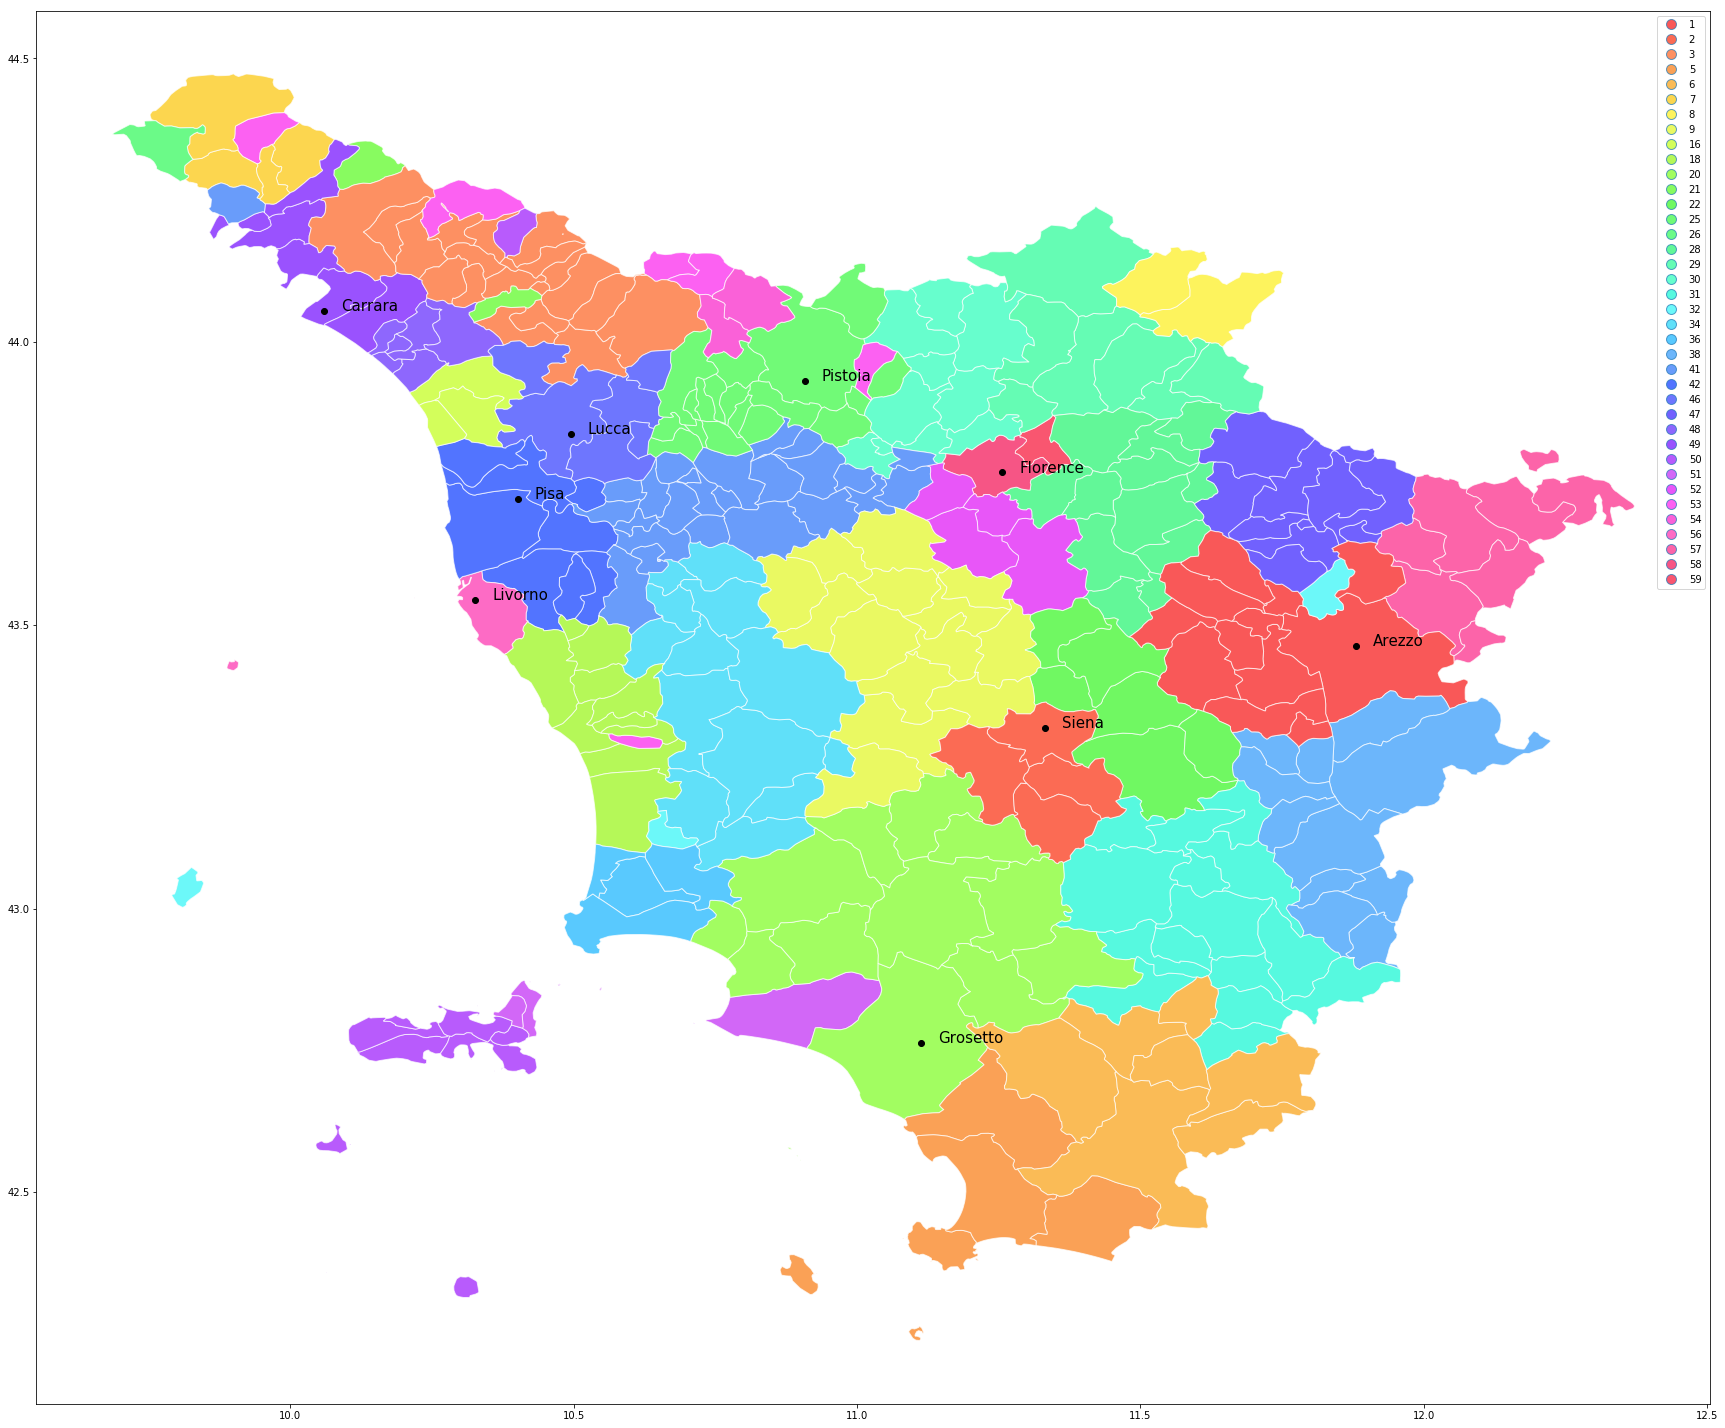

In [72]:
df_mun_tusc2.plot(column='cluster_full', colormap=cmap2, alpha=0.7, categorical=True, figsize=(30, 30), edgecolor='white', legend=True)
important_cities(df_impcit)

In [73]:
def create_cmap(df, var):
    n=len(df[var].value_counts())
    cs=get_distinct_colors(n)
    if max(df_mun_tusc2[var])==999999.0:
        cs[-1]=(1,1,1)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cs)
    return cmap

In [74]:
# rails and roads
rails_file = r"/mnt/data/shared/ITA_shapefiles/ITA_rails.shp"
roads_file = r"/mnt/data/shared/ITA_shapefiles/ITA_roads.shp"

df_roads = gpd.read_file(roads_file)
df_rails = gpd.read_file(rails_file)

tusc_roads = df_roads[df_roads.within(df_reg_tusc['geometry'][8])]
tusc_rails = df_rails[df_rails.within(df_reg_tusc['geometry'][8])]

/home/ovasarhelyi/.conda/envs/velf/lib/python3.6/site-packages/geopandas/plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


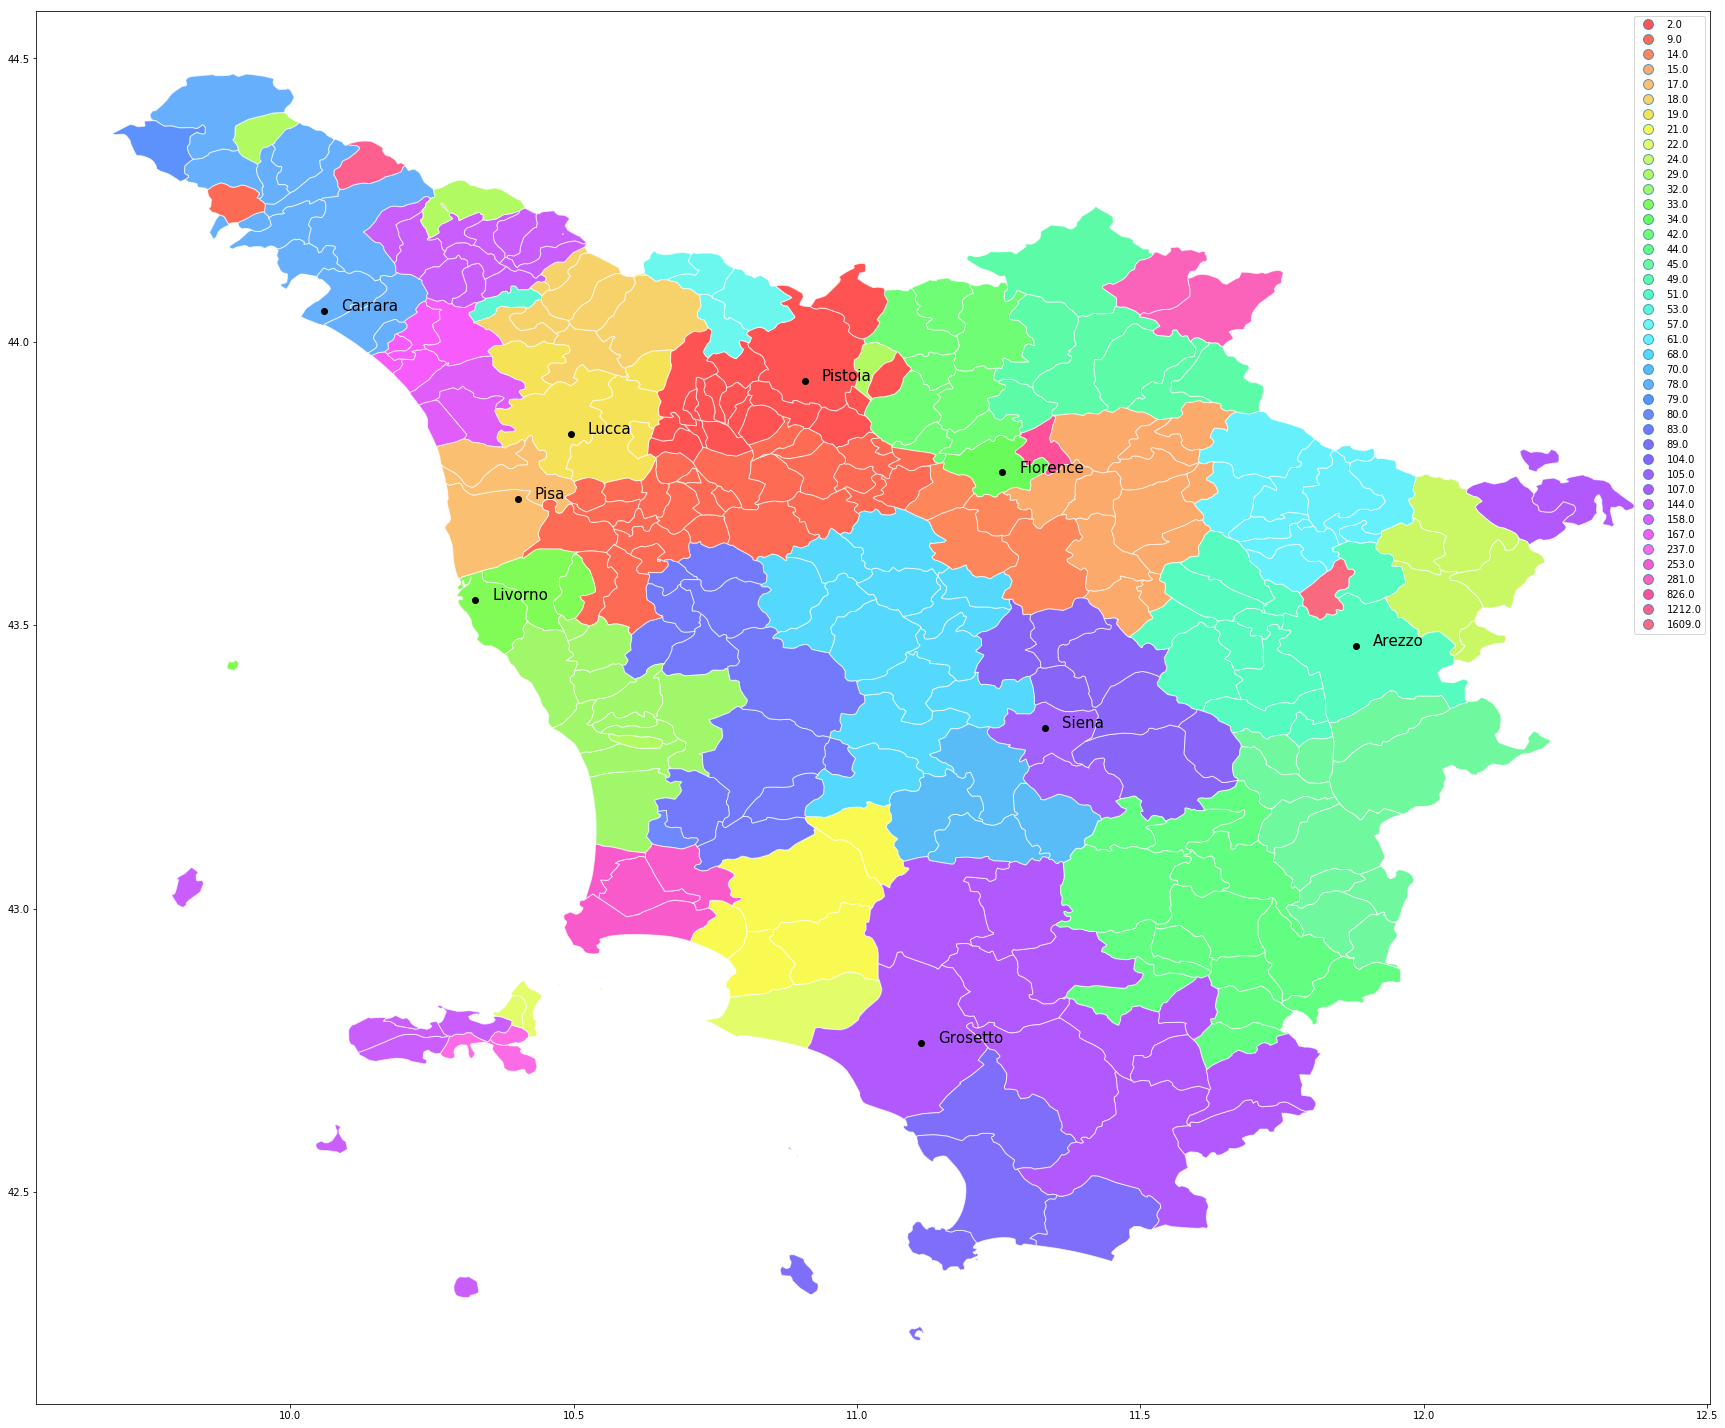

In [75]:
#df_mun_tusc2=df_mun_tusc2.replace(np.nan,999999.)
cmap6=create_cmap(df_mun_tusc2, "cluster_filtered")
ax=df_mun_tusc2.plot(column='cluster_filtered', colormap=cmap6, alpha=0.7, categorical=True, figsize=(30, 30), edgecolor='white', legend=True)
important_cities(df_impcit)
#tusc_roads.plot(ax=ax, color='red', alpha=0.5, label='Roads')
#tusc_rails.plot(ax=ax, color='black', alpha=0.5, label='Rails')
